# Preisbasierte Faktoren: Momentum und Reversal

## Hintergrund und Motivation

Bei **Momentum** bzw. **Reversal** handelt es sich um Trendfolge- bzw. Trendumkehr-Strategien. Der zugrundeliegende Faktor ist dabei die Aktienrendite gemessen über einen vergangenen Zeitraum. Bei Momentum basiert die Wette darauf dass zumindest kurzfristig Past Winner auch Future Winner sind, bzw. Past Loser auch Future Loser bleiben. Bei Reversal ist die Wette genau umgekehrt, Winner werden zu Losern und Loser zu Winnern. 

Der **Momentum-Effekt** wurde in der im Jahr 1993 erschienenen Studie (*Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency, Journal of Finance, S. 65-91*) von Jegadeesh und Titman erstmals umfangreich quantitativ belegt. Die Autoren zeigten für den Zeitraum von 1965 bis 1989, dass eine Handelsstrategie, welche die 10% der stärksten (schwächsten) Aktien kauft (leerverkauft), über einen Zeitraum von 3 bis 12 Monaten deutlich positive Renditen erzielt. Konkret berechnen die Autoren für eine jeweils 6-monatige Ranking- und Holding-Periode eine jährliche Überrendite von 12,01% vor Transaktionskosten. Eine lesenswerte Zusammenfassung der umfangreichen Momentum-Literatur gibt Gränitz (2014, S. 12-39). 

Das Phänomen der kurzfristigen Renditeumkehr, der sogenannte **Short-Term Reversal (STR) Effekt**, ist ein am Aktienmarkt seit mehr als 40 Jahren etabliertes Phänomen, das sich als robust und als ökonomisch und statistisch signifikant erwiesen hat. Jegadeesh (1990) zum Beispiel dokumentiert Gewinne von etwa 2% pro Monat über den Zeitraum 1934-1987 mit einer Umkehrstrategie, die Aktien auf der Grundlage ihrer Vormonatsrenditen kauft und verkauft und sie dann für einen Monat hält. Diese Gewinne lassen sich nicht durch direkte Transaktionskosten erklären. Weitere wichtige Arbeiten zum STR Effekt liefern Lehmann (1990), Lo und MacKinlay (1990), Nagel (2012), und Da, Liu und Schaumburg (2014). 


## Beginn der Fallstudie

In [1]:
# import of necessary libaries
import numpy as np
import pandas as pd

Für unsere beispielhafte Implementierung einer faktorbasierten Momentum bzw. Reversal Strategie wählen wir als Anlageuniversum die Aktien des S&P500. Wir laden Preishistorien für alle Indexmitglieder für den Zeitraum 3.1.2017 - 14.11.2019 aus Yahoo Finance.  

In [2]:
cd "C:\Users\Galina\Documents\Thomas\Python Projekte\examplefiles"

C:\Users\Galina\Documents\Thomas\Python Projekte\examplefiles


In [3]:
# load file from disk
px = pd.read_csv('s&p_500_15112019.csv', 
                   parse_dates=True, index_col=0)
px = px.asfreq('B').fillna(method='pad')

In [5]:
px.tail(2)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-13,84.220001,86.660004,220.009995,194.50,52.330002,293.540009,37.520000,158.580002,18.15,84.690002,...,187.619995,118.839996,61.639999,37.599998,93.290001,75.769997,98.379997,144.369995,49.630001,116.449997
2019-11-14,84.120003,87.629997,220.949997,196.25,52.700001,294.529999,38.349998,156.830002,18.41,84.260002,...,189.750000,118.680000,61.299999,38.650002,93.150002,76.510002,98.110001,145.029999,49.500000,116.250000


### Implementierung 1: gleichgewichtete Dezil-Portfolios

Faktorstrategien können auf unterschiedliche Arten implementiert werden. Ein Standardverfahren ist es Aktien nach den Ausprägungen eines Faktors (hier: vergangene Renditen) in Dezile zu sortieren. Um die Strategie marktneutral zu halten wird in die Aktien des Dezil's 10 "Long gegangen", und das Dezil 1 wird "geshortet". Die Strategie ist also ein Long-Short (Dezil 10-1) Ansatz. Die Aktien innerhalb der Dezile werden dabei am Anfang gleichgewichtet. Nach einer festgelegten Halteperiode kommt es zu einem Rebalancing (Neubestimmung der Dezile und Rückführung der Positionen auf eine Gleichgewichtung). 

Lassen Sie uns beginnen und die Aktien des S&P500 an jedem Handelstag anhand ihrer vergangenen 20-Tagesrendite in Gruppen sortieren. Zunächst berechnen wir für jeden Tag t die diskrete Rendite für den Zeitraum von t-1 bis t-21. Dies geschieht durch `px.shift(1).pct_change(20)`. Wir speichern die Renditen im DataFrame `ret_df`. Dann bringen wir die Aktien über die Methode `rank(axis=1, pct=True)` in eine Perzentil-Rankordnung gemäß der vergangenen 20-Tagesrendite. Aus den Perzentilen können wir Dezile generieren indem wir mit 10 multiplizieren (`mul(10)`) und dann auf die nächste ganze Zahl aufrunden (`np.ceil`). Wollen wir Aktien alternativ in Quintile sortieren, multiplizieren wir einfach mit 5 (`mul(5)`). Wichtig: durch die Festlegung `ascending=False` werden Aktien mit den höchsten (geringsten) Renditen in Gruppe 1 (10) sortiert. Äquivalent werden bei `ascending=True` die Past Winner in Gruppe 10 und die Past Loser in Gruppe 1 sortiert. 

In [5]:
ret_df = px.shift(1).pct_change(20)
rank_df = np.ceil(ret_df.rank(axis=1, pct=True, ascending=False).mul(10))
rank_df.tail(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-08,6.0,3.0,1.0,6.0,7.0,5.0,1.0,4.0,3.0,1.0,...,8.0,1.0,10.0,1.0,6.0,7.0,10.0,5.0,2.0,9.0
2019-11-11,5.0,1.0,1.0,6.0,8.0,5.0,1.0,5.0,3.0,2.0,...,8.0,2.0,9.0,1.0,7.0,7.0,10.0,5.0,1.0,10.0
2019-11-12,5.0,1.0,1.0,6.0,9.0,5.0,1.0,4.0,2.0,1.0,...,8.0,4.0,9.0,1.0,8.0,8.0,10.0,5.0,1.0,10.0
2019-11-13,6.0,1.0,1.0,6.0,10.0,5.0,1.0,8.0,2.0,1.0,...,7.0,5.0,9.0,1.0,8.0,8.0,10.0,5.0,2.0,10.0
2019-11-14,6.0,1.0,1.0,5.0,10.0,3.0,1.0,9.0,2.0,2.0,...,7.0,5.0,9.0,1.0,8.0,9.0,10.0,4.0,2.0,10.0


Wir transformieren das DataFrame `rank_df` nun in ein DataFrame mit Positionsindikatoren: -1 für eine Short Position in Dezil 1 Aktien, 0 für eine Flat (d.h. keine) Position in Aktien der Dezile 2 bis 9, und 1 für eine Long Position in Dezil 10 Aktien. 

**Beachten Sie**: Da wir Long in Dezil 10 und Short in Dezil 1 gehen, implementieren wir durch die Wahl von `ascending=True` eine Momentum Strategie, und durch `ascending=False` eine Reversal Strategie!

In [6]:
for col in rank_df.columns:
    rank_df[col] = np.where(rank_df[col]>9.0, 1, np.where(rank_df[col]<2.0, -1, 0))

rank_df.tail(5)

,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AMG,...,WLTW,WYNN,XEL,XRX,XLNX,XYL,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-08,0,0,-1,0,0,0,-1,0,0,-1,...,0,-1,1,-1,0,0,1,0,0,0
2019-11-11,0,-1,-1,0,0,0,-1,0,0,0,...,0,0,0,-1,0,0,1,0,-1,1
2019-11-12,0,-1,-1,0,0,0,-1,0,0,-1,...,0,0,0,-1,0,0,1,0,-1,1
2019-11-13,0,-1,-1,0,1,0,-1,0,0,-1,...,0,0,0,-1,0,0,1,0,0,1
2019-11-14,0,-1,-1,0,1,0,-1,0,0,0,...,0,0,0,-1,0,0,1,0,0,1


Führen wir nun alles zusammen in der Funktion `weights_dc_equal`. Diese Funktion erfordert als Eingabe ein DataFrame mit Aktienpreisen (*price*), die Angabe des Zeitraums (*lookback*) für die Berechnung der vergangenen diskreten Rendite als Ranking-Faktor, und die Anzahl der Tage (*lag*) die bis zur Implementierung der Strategie vergehen (sollen). 

In [11]:
def weights_dc_equal(price, lookback, lag):
    ret_df = price.shift(lag).pct_change(lookback)
    # Important: False = Reversal; True = Momentum!!
    rank_df = np.ceil(ret_df.rank(axis=1, pct=True, ascending=False).mul(10))
    for col in rank_df.columns:
        rank_df[col] = np.where(rank_df[col]>9, 1, np.where(rank_df[col]<2, -1, 0))
    
    return rank_df

Zudem definieren wir zwei **Lambda** Funktionen:
    
    1. "compound" berechnet aus dem Eingabe-Array x kumulative Mehr-Tagesrenditen;
    2. "daily_sr" berechnet aus einem Array von Tagesrenditen die tägliche Sharpe-Ratio;

In [8]:
# cumulative returns
compound = lambda x: (1 + x).prod() - 1

# daily Sharpe Ratio
daily_sr = lambda x: x.mean() / x.std()

Im folgenden berechnen wir zunächst für jeden Handelstag die nicht-normierten Aktiengewichte (-1: Short; 0: Flat; 1: Long) durch Anwendung unserer Funktion `weights_dc_equal`. Das resultierende DataFrame nennen wir `port`. Dann legen wir die Anzahl der Handelstage (*hold*) fest, für die wir das Portfolio halten wollen ohne die Gewichte umzuschichten. 

Im letzten Schritt reduzieren wir die Zeitfrequenz von `port` auf die Länge (*hold*) der gewählten Portfoliohalteperiode, setzen die Gewichte auf die Werte die zu Beginn der Halteperiode gelten (über `.first()`), und wählen `.shift(1)`, da in t nur die Gewichte die zum Zeitpunkt t-1 bekannt sind implementiert werden können.   

In [12]:
hold = 5
freq = '%dB' % hold # holding period 
port = weights_dc_equal(px, 20, lag=1) # security weights at business day freq
port = port.shift(1).resample(freq).first() # time series with 'freq' as frequency

Dann berechnen wir die kumulativen Renditen jeder Aktie für die gewählte Portfoliohaltedauer. Hierzu verwenden wir die vorher definierte Lambda-Funktion `compound`.  

In [14]:
# calculation of daily security returns
daily_rets = px.pct_change()
    
# calculation of portfolio returns, shift(1) for implementation lag
returns = daily_rets.resample(freq).apply(compound)

Danach multiplizieren wir für jede der einzelnen Halteperioden die kumulativen Aktienrenditen mit den Positionsindikatoren (-1, 0, 1), summieren die Produkte über alle Aktien auf, und teilen durch die Summe aller offen (Long und Short) Positionen um eine gleichgewichtete Portfoliorendite zu bekommen. Die resultierende Zeitreihe der kumulativen Portfoliorenditen nennen wir `portf_rets`. Sie hat dieselbe Zeitfrequenz wie *freq*, die Portfoliohaltedauer in Anzahl Handelstage. Wenden wir unsere Lambda-Funktion `daily_sr`auf die Zeitreihe der Portfoliorenditen an und skalieren mit `np.sqrt(252/hold)` erhalten wir die annualisierte Sharpe-Ratio der Strategie. 

In [15]:
# security returns * position direction (-1, 0, 1)
portf = np.multiply(port, returns) 
# summing position returns divided by number of positions
portf_rets = portf.sum(axis = 1)/(portf != 0).sum(axis =1)

Lassen Sie uns nun die obigen Schritte in der Strategie-Funktion `strat_dc_equal` zusammenfassen. Wir benötigen ein DataFrame (*prices*) mit Aktienkursen, die Länge der lookback (*lb*) Periode zur Berechnung des Preisfaktors, und die Länge der Portfoliohaltedauer (*hold*). 

In [20]:
# strategy function
def strat_dc_equal(prices, lb, hold):
    # calculation of security weights: (-1: short, 0: no, 1: long)
    freq = '%dB' % hold # holding period 
    port = weights_dc_equal(prices, lb, lag=0) # security weights at business day freq
    
    # calculation of daily security returns
    daily_rets = prices.pct_change()
    
    # calculation of portfolio returns, shift(1) for implementation lag
    port = port.shift(1).resample(freq).first() # time series with 'freq' as frequency
    returns = daily_rets.resample(freq).apply(compound)
    portf = np.multiply(port, returns) # security returns * position direction (-1, 0, 1)
    # summing position returns divided by number of positions
    portf_rets = portf.sum(axis = 1)/(portf != 0).sum(axis =1)
    
    return portf_rets, daily_sr(portf_rets) * np.sqrt(252/hold)

Führen wir die Strategie nun beispielhaft mit einer Halteperiode von einem Tag aus. Die Aktien des S&P500 werden anhand ihrer vergangenen 5-Tagesrendite sortiert. Da in der Funktion `weights_dc_equal` `ascending=False` festgelegt ist, gehen wir also Long in die extremen 10% der vergangenen 5-Tages Loser und Short in die extremen 10% der vergangenen 5-Tages Winner. Wir wetten also auf ein Short-Term Reversal!

In [21]:
_, sharpe_equal = strat_dc_equal(px,5,1)

In [22]:
sharpe_equal

0.3033419609996148

### Implementierung 2: Marktwert-gewichtete Dezil-Portfolios



Alternativ zur Gleichgewichtung bei Portfoliobildung können die Aktien in den beiden Portfolios (Dezil 10 und 1) auch Marktwert-gewichtet (value-weighted) werden. Hierzu benötigt man die Informationen zur täglichen Marktkapitalisierung (Schlusskurs * Anzahl emittierter Aktien) einer Aktie. Zur Veranschaulichung des Konzepts und der Implementierung verwenden wir im folgenden nur Daten zu Kursen und zur Marktkapitalisierung der S&P500 Aktien für einen Monat (18.11.2019 - 17.12.2019). Wir generieren aus dem Excel File *"SnP500 1monat Schlusskurse und MarketCaps"* zwei DataFrames: `df.px` mit den Schlusskursen und `df.market_cap` mit der täglichen Marktkapitalisierung (in Dollar) der S&P500 Aktien. 

In [32]:
xlsx = pd.ExcelFile('SnP500 1monat Schlusskurse und MarketCaps.xlsx')

df = pd.read_excel(xlsx, 'Sheet3', header=[0,1], index_col=0)
df = df.swaplevel(0,1, axis=1).sort_index(axis=1, level=0)
df = df.rename(columns={'px_last(dates=range(-1m,0d))': 'px', 'market_cap(dates=range(-1m,0d))': 'market_cap'})

# giving names to the index/column labels
df.columns.names = ['var', 'ticker']
df.index.name = 'date'

# dropping the last 10 strings in the ticker labels
drop_last_letters = lambda x: x[0:-10]
df.columns.set_levels(df.columns.levels[1].map(drop_last_letters),level=1,inplace=True)

# setting frequency to business days
df = df.asfreq('B').ffill()

In [37]:
df.px.head(3)

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-11-18,77.94,28.60,163.67,267.10,88.73,87.77,178.09,84.26,198.02,297.16,...,60.88,92.38,68.52,56.27,39.30,77.31,98.28,144.99,49.305,118.80
2019-11-19,79.29,29.29,161.98,266.29,89.02,87.81,184.34,84.29,198.34,300.60,...,61.32,92.80,67.82,56.39,38.69,78.00,98.08,144.54,49.300,120.33
2019-11-20,78.52,28.23,161.74,263.19,87.20,87.55,185.25,83.89,197.71,300.10,...,61.69,91.01,68.03,56.63,38.30,77.47,98.12,142.57,48.885,119.56


In [36]:
df.market_cap.head(3)

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2019-11-18,2.411991e+10,1.252846e+10,1.133569e+10,1.186796e+12,1.312158e+11,1.828473e+10,8.041673e+09,1.490101e+11,1.259452e+11,1.438488e+11,...,3.192475e+10,2.323056e+10,2.899154e+11,1.251522e+10,8.496199e+09,1.392190e+10,2.972598e+10,2.982218e+10,8.404721e+09,5.658435e+10
2019-11-19,2.453769e+10,1.283072e+10,1.121864e+10,1.183197e+12,1.316447e+11,1.829306e+10,8.323893e+09,1.490631e+11,1.261487e+11,1.455140e+11,...,3.215548e+10,2.333617e+10,2.869536e+11,1.254191e+10,8.364324e+09,1.404615e+10,2.966549e+10,2.972962e+10,8.403869e+09,5.731309e+10
2019-11-20,2.429940e+10,1.236638e+10,1.120201e+10,1.169423e+12,1.289532e+11,1.802849e+10,8.364984e+09,1.483557e+11,1.257480e+11,1.452720e+11,...,3.234950e+10,2.288605e+10,2.878421e+11,1.259529e+10,8.280010e+09,1.395071e+10,2.967759e+10,2.932442e+10,8.333126e+09,5.694634e+10


Nachdem wir wie oben unser DataFrame `rank_df` mit den Positionsindikatoren (-1: Short; 0: Flat; 1: Long) erstellt haben, generieren wir daraus ein Dataframe `ranks_long` mit Positionsindikatoren (Einsen und Nullen) für Long Positionen und ein separates (`ranks_short`) für Short Positionen. Wir gewichten die "Einsen" mit der aktuellen Marktkapitalisierung der Aktie und normieren (teilen) durch die Summe der Marktkapitalsierungen aller Aktien in jedem der beiden Portfolios. Im Ergebnis erhalten wir ein DataFrame mit den täglichen Marktwert-basierten Gewichten für das Long Portfolio und eins für das Short Portfolio. Fassen wir die einzelnen Schritte in der Funktion `weights_dc_value` zusammen. 

In [38]:
# value weights function
def weights_dc_value(df, lookback, lag):
    ret_df = df.px.shift(lag).pct_change(lookback)
    # Important: False = Reversal; True = Momentum!
    rank_df = np.ceil(ret_df.rank(axis=1, pct=True, ascending=False).mul(10))
    for col in rank_df.columns:
        rank_df[col] = np.where(rank_df[col]>9, 1, np.where(rank_df[col]<2, -1, 0))
 
    # weights separately for the long and the short leg
    ranks_short = rank_df.replace(1, 0)
    ranks_long = rank_df.replace(-1, 0)
    short_vranks = np.multiply(ranks_short, df.market_cap.shift())
    long_vranks = np.multiply(ranks_long, df.market_cap.shift())


    weights_short = short_vranks.div(short_vranks.sum(axis =1), axis=0)
    weights_long = long_vranks.div(long_vranks.sum(axis =1), axis=0)

    return weights_long, weights_short

Wir berechnen nun für das Long und das Short Portfolio separat die täglichen Gewichte, und verwenden die Gewichte zum Zeitpunkt t-1 für eine Halteperiode die in t beginnt. Mit diesen Gewichten multiplizieren wir die kumulativen Renditen der Aktien über die Halteperiode um die Portfoliorendite der Halteperiode zu bekommen. Die Strategierendite der Halteperiode ist die Differenz zwischen der Halteperiodenrendite des Long und des Short Portfolios. Wir fassen diese Schritte in der Strategiefunktion `strat_dc_value` zusammen. 

In [39]:
# strategy function
def strat_dc_value(df, lb, hold):
    # calculation of security value-weights
    freq = '%dB' % hold # holding period 
    weights_long, weights_short = weights_dc_value(df, lb, lag=0) # security weights at business day freq
    
    # calculation of daily security returns
    daily_rets = df.px.pct_change()
    returns = daily_rets.resample(freq).apply(compound)
    
    # calculation of portfolio returns, shift(1) for implementation lag
    # first for the long leg
    w_long = weights_long.shift(1).resample(freq).first() # time series with 'freq' as frequency
    returns_long = np.multiply(w_long, returns).sum(axis=1) # security returns * position direction (-1, 0, 1)
    
    # and now for the short leg
    w_short = weights_short.shift(1).resample(freq).first() # time series with 'freq' as frequency
    returns_short = np.multiply(w_short, returns).sum(axis=1) # security returns * position direction (-1, 0, 1)
    
    # portfolio returns = returns_long - returns_short
    portf_rets = returns_long - returns_short

    return portf_rets, daily_sr(portf_rets) * np.sqrt(252/hold)

In [42]:
_, sharpe_value = strat_dc_value(df,2,1)

In [43]:
sharpe_value

0.3585974000725961

### Implementierung 3: Gewichte nach Frazzini und Pedersen (2014)



Der Ansatz von Frazzini und Pedersen (FP) (*Betting Against Beta, Journal of Financial Economics, 2014, S. 1-25*) sieht nicht die Bildung von Dezilen (oder Quintilen, etc.) vor. Im Gegensatz dazu wird in jede Aktie investiert, und zwar abhängig davon wie stark und in welche Richtung der Perzentil-Rang einer Aktie vom durchschnittlichen Rang aller Aktien abweicht. In Aktien mit negativen Abweichungen wird Short gegangen und in Aktien mit positiven Abweichungen wird eine Long Position aufgebaut. Das Gewicht jeder Aktie ergibt sich aus der Rangabweichung der Aktie vom mittleren Rang skaliert mit der (d.h. geteilt durch die) Hälfte der Summe der absoluten Rangabweichungen über alle Aktien. Das Long Portfolio hat damit wieder ein Gewicht von 1, und das Short Portfolio von -1. 

Zur Implementierung der FP Gewichte erstellen wir das gewohnte (tägliche) DataFrame `ranks` mit den Perzentil-Rängen der Aktien gemäß ihrer Rendite über eine vergangene lookback Periode. Daraus erstellen wir ein neues DataFrame `demeaned` mit Rangabweichungen indem wir jeweils den Zeilenmittelwert (`ranks.mean(axis=1)`) der Ränge vom Rang einer Aktie abziehen. Zusätzlich enthält das DataFrame `abs_demeaned` die absoluten Rangabweichungen. Wir bekommen die finalen FP Gewichte (DataFrame `weights`) indem wir die Zeilenwerte von `demeaned` durch die Hälfte der korrespondierenden Zeilensumme von `abs_demeaned` teilen. 

Fassen wir diese Schritte nun in der Gewichtsfunktion `weights_fp` zusammen. Alle weiteren Schritte erfolgen analog zur obigen Vorgehensweise. Die Strategiefunktion nenne ich `strat_fp`.  

In [28]:
# first, definition of the weight function
def weights_fp(price, lookback, lag):
    # weights according to Frazzini and Pedersen (2014), equation (16), p. 9
    ret = price.shift(lag).pct_change(lookback)
    ranks = ret.rank(ascending=False, axis=1, pct=True) # percentile ranks
    # important: False = Reversal; True = Momentum!
    demeaned = ranks.sub(ranks.mean(axis=1), axis='index') # cross-sectional demeaned
    abs_demeaned = abs(demeaned) 
    # demeaned percentile ranks normalized by 0.5 * cross-sectional sum of abs. demeaned weights
    weights = demeaned.div(0.5 * abs_demeaned.sum(axis=1), axis='index')
    return weights


# strategie returns (main function)
def strat_fp(prices, lb, hold):
    # portfolio weights
    freq = '%dB' % hold # holding period in number of business days
    port = weights_fp(prices, lb, lag=0) #weights for each business day
    
    # daily returns
    daily_rets = prices.pct_change()
    
    # strategy returns
    port = port.shift(1).resample(freq).first() # time series with holding period freq
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1) # weighted sum of security returns 
    
    return port_rets, daily_sr(port_rets) * np.sqrt(252/hold)
    

In [29]:
_, sharpe_fp =strat_fp(px,5,1)

In [30]:
sharpe_fp

0.3799827125498262

### Optimierung der Lookback und Halteperioden

Lassen Sie uns zum Abschluss unsere Momentum bzw. Reversal Faktorstrategie optimieren indem wir mit einem "Brute Force" Ansatz nach der für die Backtestperiode optimalen Länge des Lookback Fensters und der Halteperiode suchen. Beachten Sie das **Overfitting Risiko**: die optimalen Längen ermittelt für die Backtestperiode werden mit hoher Wahrscheinlichkeit nicht optimal für eine *Out-of-Sample* Periode sein. 

Wir erstellen dabei ein DataFrame `ddf` mit Zeilen für unterschiedliche Halteperioden (zwischen 1 und 10 Tagen mit Schrittlänge 2 Tagen) und Spalten für unterschiedliche Lookback Fensterlängen (zwischen 2 und 20 Tagen mit Schrittlänge 2 Tagen). Die Zellen des DataFrames enthalten die entsprechenden annualisierten Strategie Sharpe-Ratios. 

In [50]:
from collections import defaultdict

lookbacks = range(2, 20, 2)
holdings = range(1, 10, 2)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        _, dd[lb][hold] = strat_dc_equal(px, lb, hold)
        
ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [51]:
ddf

Lookback Period,2,4,6,8,10,12,14,16,18
Holding Period,,,,,,,,,
1,0.586479,0.622767,0.263583,0.386647,0.478552,0.770722,0.368714,0.612923,0.384949
3,0.637111,0.824397,0.484336,0.532511,0.743088,0.744577,0.771689,0.714077,0.537295
5,0.081747,0.035580,0.576375,0.997212,0.839344,0.582970,0.430892,0.803945,0.662032
7,-0.543289,-0.190297,0.461219,0.686883,0.362453,0.525375,0.449932,0.688291,0.502556
9,0.236476,0.585773,0.339001,0.389064,0.438899,0.555245,0.645081,0.401152,0.500175


<IPython.core.display.Javascript object>


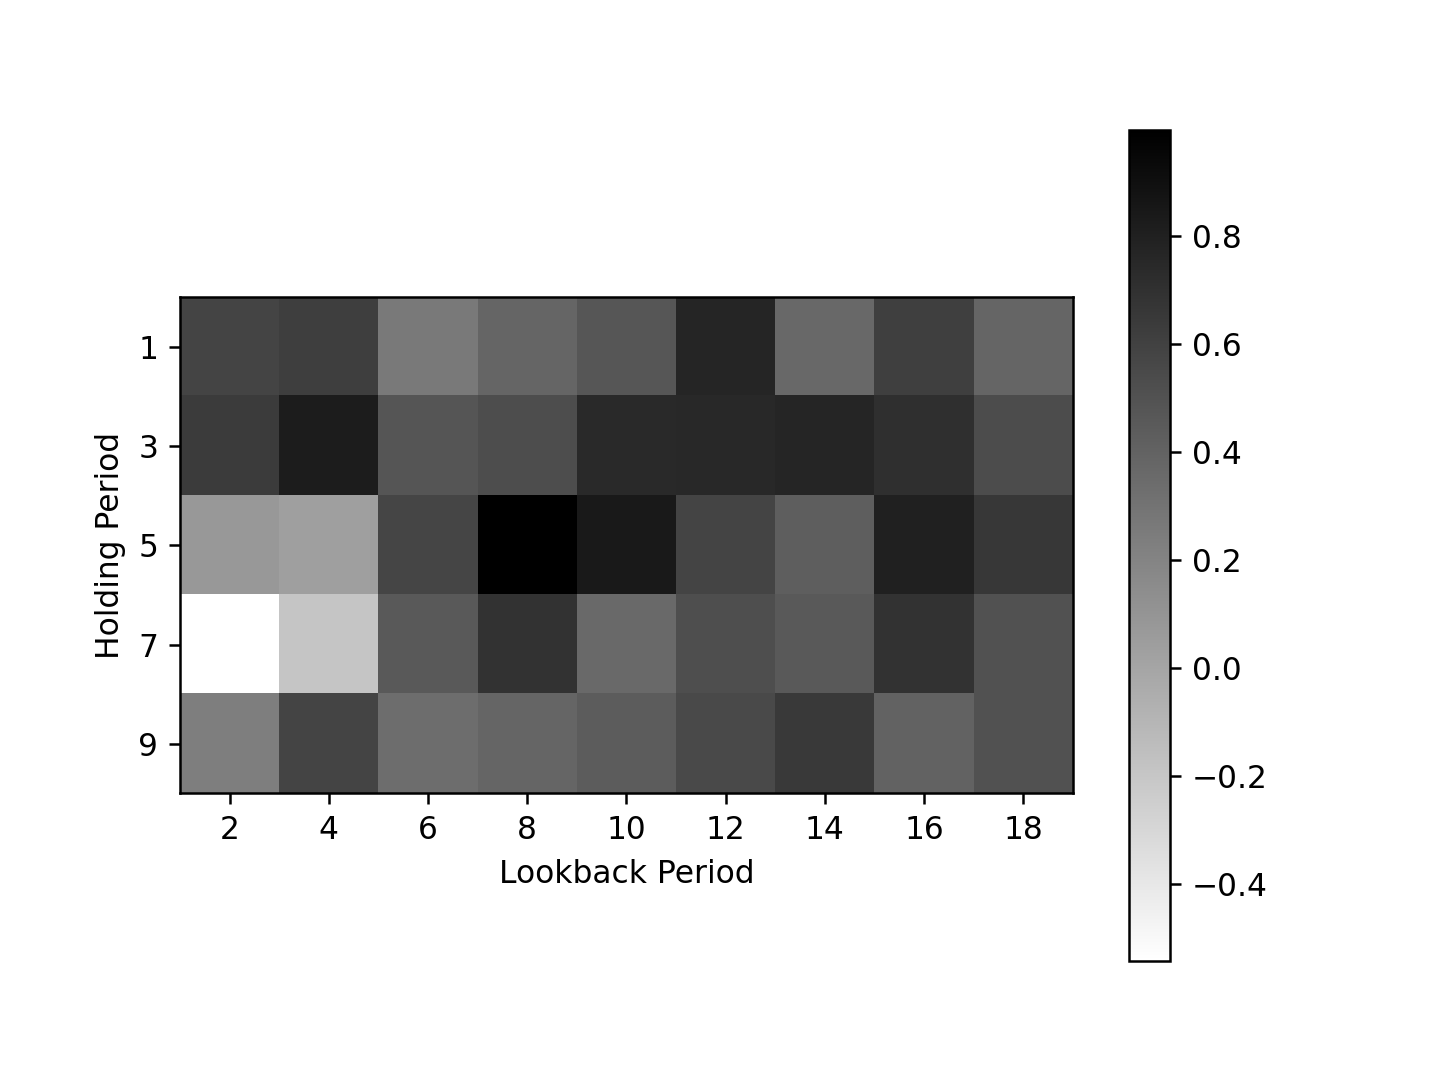

In [52]:
# heatmap
import matplotlib.pyplot as plt
%matplotlib notebook

def heatmap(df, cmap=plt.cm.gray_r):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)
    
heatmap(ddf)